In [3]:
!pip install pytesseract
import pytesseract as tess
#!apt install tesseract-ocr
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage import data
import os
import pandas as pd
import re
import torch
from torchvision import transforms

!pip install opencv-python-headless --user

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(True)



In [4]:
#Define your path for pytesseract
tess.pytesseract.tesseract_cmd = r"C:\Users\adria\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"
#tess.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The date of the purchase is: 03 Mar 2018. Confidence: 77.732277.
The postal code of the purchase address is: 81200 Johor Bahru. Confidence: 83.260422.
The total amount to pay was: Total: $8.20. Confidence: 32.277840.


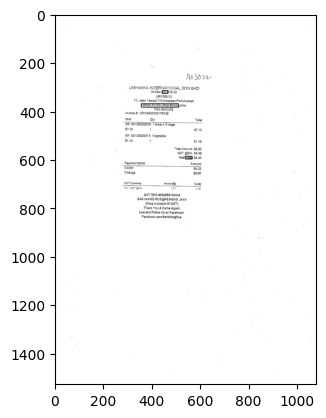

In [55]:
img_name='032.jpg'

date,pc,total=draw_bbox(img_name,n=0)


In [54]:
def preprocess(img,n=1):
    if len(img.shape)>2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.equalizeHist(img)
    for i in range(n):
        img = cv2.GaussianBlur(img, (3,3), 0)
    
    return img


def get_date(text):
  pattern1 = re.compile(r'\b\d{2}[-/ ]\d{2}[-/ ](?:\d{2}|\d{4})\b') #dd-mm-yy or dd-mm-yyyy or dd/mm/yy or dd/mm/yyyy
  pattern2 = re.compile(r'\b(0?[1-9]|[12][0-9]|3[01])(?:st|nd|rd|th)?\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+(\d{4})\b', re.IGNORECASE)
  #patter 2 is for dd Month yyyy
  pattern3 = re.compile(r'\b((?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*)\s+(0?[1-9]|[12][0-9]|3[01])((?:st|nd|rd|th)?)\s+(\d{4})\b', re.IGNORECASE)
  #pattern3 for March 3rd 2000

  patterns=[pattern1,pattern2,pattern3]
    
  for i,p in enumerate(patterns):
    date=re.findall(p,text)
    
    if date:

      if type(date[0])==tuple:
              
        return ' '.join(date[0])
      
      return date[0]


  return (' ')

def get_pc(text):
    postal_code_pat = re.compile(r'\b\d{5,8}\s*[A-Za-z\s]+\b')
    postal_code = re.findall(postal_code_pat, text)

    if postal_code:

        postal_code=postal_code[0].split('\n')
        postal_code=postal_code[0]
        return postal_code
    else:
        return ' '
    

def get_strn(text):
    st_no_pat = re.compile(r'(NO\.*|No\.*)\s*\d+[./]*\d*\s*,*\s*JALAN\s\w+\s*\d+[./]*\d*',re.IGNORECASE)
    st_no = re.findall(st_no_pat, text)
    if st_no:
        st_no=st_no[0].split('\n')
        st_no=st_no[0]
        return st_no
    else:
        return ' '

def get_total(text):
  pay_pat=re.compile(r'\btotal\b.*?\d+(?:\.\d+)?',re.IGNORECASE)
  payment=re.findall(pay_pat, text)
  if payment:
    return payment[-1]
  else:
    return ' '


def get_df_img(list_images,n=1):
    img_text_list=[]
    for i,img_name in enumerate(list_images):
        
        img=cv2.imread(img_name)
        img=preprocess(img,n)
        
        #text from the image
        text=tess.image_to_string(img)
        
        # #data from the image
        # img_data=tess.image_to_data(img)
        # data = [d.split("\t") for d in img_data.split("\n")]
        # columns = data[0]
        # data = data[1:-1]
        # df = pd.DataFrame(data, columns=columns)

        #date,postal code, strn from the image
        date=get_date(text)
        pc=get_pc(text)
        strn=get_strn(text)
        total=get_total(text)

        img_text_list+=[[img_name,text,date,pc,strn,total]]
        
    df_img= pd.DataFrame(img_text_list, columns=['img name', 'found text','found date','found pc','found strnum','found total'])
    return df_img


def get_df_data(img_name,n):
  img=cv2.imread(img_name)
  img=preprocess(img,n)
  img_data=tess.image_to_data(img)

  data = [d.split("\t") for d in img_data.split("\n")]
  columns = data[0]
  data = data[1:-1]
  df = pd.DataFrame(data, columns=columns)
  return df


def get_idx(found,df):

  idx_el=[]

  for el in found.split():
     
    row_el=df[df['text'].str.contains(el,case=False)]
     
    if len(row_el)==1:
      idx_el+=[row_el.index[0]]
       
  return(idx_el)

def get_idx_total(found,df):

  idx_el=[]

  for el in found.split():
     
    row_el=df[df['text'].str.contains(el,case=False)]
     
    if not row_el.empty:
      idx_el+=[row_el.index[-1]]
       
  return(idx_el)


def get_max_w_h(idxs,df_data):
    max_xw=0
    max_yh=0
    for pos,id in enumerate(idxs):

        x,w=int(df_data['left'].iloc[id]),int(df_data['width'].iloc[id])
        if x+w>max_xw:
            max_xw=x+w
            id_max_xw=id

        y,h=int(df_data['top'].iloc[id]),int(df_data['height'].iloc[id])
        if y+h>max_yh:
            max_yh=y+h
            id_mx_yh=id

    return(max_xw,max_yh)


def draw_bbox(img_name,n):
  img=cv2.imread(img_name)
  img=preprocess(img,n)

  img_bbox_word=np.copy(img)
  h_im,w_im=img_bbox_word.shape

  df_img=get_df_img([img_name],n)
  df_data=get_df_data(img_name,n)

  row=df_img[df_img['img name']==img_name]
  idx=row.index[0]

  found_date,found_pc,found_total=df_img.iloc[idx]['found date'],df_img.iloc[idx]['found pc'],df_img.iloc[idx]['found total']
  
  #df_nb=df_data[df_data['text']!='']
  row_date,row_pc,row_total=df_data[df_data['text']==found_date],df_data[df_data['text']==found_pc],df_data[df_data['text']==found_total]
  

  rows_text=[(found_date,row_date),(found_pc,row_pc),(found_total,row_total)]

  conf=[]
  for found,row in rows_text:
    if len(row)!=0:
      idx_row=row.index[0]
      x, y, w, h = int(df_data['left'].iloc[idx_row]), int(df_data['top'].iloc[idx_row]), int(df_data['width'].iloc[idx_row]), int(df_data['height'].iloc[idx_row])
      img_bbox_word=cv2.rectangle(img_bbox_word, (x,y), (w+x, h+y), (0, 0, 255), 2)
      plt.imshow(img_bbox_word,cmap='gray')

      confidence=df_data['conf'].iloc[idx_row]
      conf+=[(found,confidence)]

    if len(row)==0:
      if found==found_total:
        idxs=get_idx_total(found,df_data)
      else:
        idxs=get_idx(found,df_data)
      
      first=idxs[0]
    
      x1,y1,w1,h1 = int(df_data['left'].iloc[first]), int(df_data['top'].iloc[first]),int(df_data['width'].iloc[first]), int(df_data['height'].iloc[first])
      w,h=get_max_w_h(idxs,df_data)

      img_bbox_word=cv2.rectangle(img_bbox_word, (x1,y1), (w, h), (0, 0, 255), 2)
      plt.imshow(img_bbox_word,cmap='gray')

      confidence=df_data['conf'].iloc[idxs[-1]]
      conf+=[(found,confidence)]

  ticket_summary(conf)
  return conf

# indexes=np.random.randint(0,len(list_images),size=10)

# l=[list_images[i] for i in indexes]

#df_img=get_df_img(l,n)

def ticket_summary(items):
  date,pc,total=items

  text_date = "The date of the purchase is: " + date[0] +". Confidence: " + date[1] + "."
  
  
  text_pc = "The postal code of the purchase address is: " + pc[0] +". Confidence: " + pc[1] + "."
  
 
  text_pay = "The total amount to pay was: " + total[0] +". Confidence: " + total[1] + "."

  text='\n'.join([text_date,text_pc,text_pay])
  print(text)
  